In [123]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

ind_train = np.concatenate((np.where(y_cl == 0)[0][0:130], np.where(y_cl == 1)[0][:35], np.where(y_cl == 2)[0][:8], np.where(y_cl == 3)[0][:4]))
ind_test = list(set(range(0, 290)) - set(ind_train))

X = np.load('data/X_train.npy')
y = np.genfromtxt('data/train_labels_new.csv', delimiter=' ', dtype=np.float32)
y_cl = np.argmax(y, axis=1)

X_train = np.take(X, ind_train, axis=0)
y_train = np.take(y_cl, ind_train)
X_test = np.take(X, ind_test, axis=0)
y_test = np.take(y_cl, ind_test)

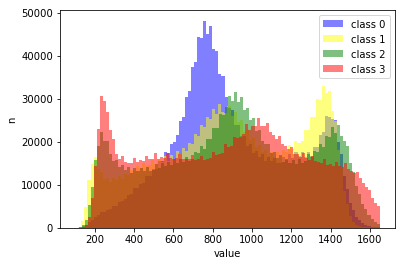

In [213]:
bins = [1, 282.10434686113894, 528.4350826042349, 635.7632261805744, 781.9301580581496, 962.0317275933281, 1079.2939329789033, 1246.3707282050862, 1393.0345691835053, 1721.8292294917992]
plt.hist(X[0][(X[0] > 100) & (X[0] < 1650) ], 100, facecolor='blue', alpha=0.5, label='class 0')
plt.hist(X[200][(X[200] > 100) & (X[200] < 1650) ], 100, facecolor='yellow', alpha=0.5, label='class 1')
plt.hist(X[276][(X[276] > 100) & (X[276] < 1650) ], 100, facecolor='green', alpha=0.5, label='class 2')
plt.hist(X[280][(X[280] > 100) & (X[280] < 1650) ], 100, facecolor='red', alpha=0.5, label='class 3')
plt.xlabel('value'); plt.ylabel('n'); plt.legend(); plt.show()
#plt.hist(y_cl, 4, facecolor='red', alpha=0.75)
#plt.xlabel('class'); plt.ylabel('n'); plt.show()

#from sklearn.metrics import accuracy_score
#f1_score([0, 1, 2], [0, 2, 1], average='micro')

In [223]:
from sklearn.base import BaseEstimator, TransformerMixin
import random
random.seed(99)

class RandomBinsExtraction(BaseEstimator, TransformerMixin):
    """Build n bins with mean from values"""
    def __init__(self, splits=610, hist_bins=None,
        images_x_from=None, images_x_to=None,
        images_y_from=None, images_y_to=None):

        self.splits = splits
        self.hist_bins = hist_bins

        self.images_x_from = images_x_from
        self.images_x_to = images_x_to
        self.images_y_from = images_y_from
        self.images_y_to = images_y_to
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = []
        if self.hist_bins is None:
            self.hist_bins = [[1, 349.57938688820047, 514.3746932858628, 669.4300432252885, 813.46816874832098, 950.71415810026383, 1094.3331288316649, 1245.2794633697374, 1390.4908175139283, 1700]]
            self.hist_bins = [[1, 298.8218117717887, 415.59953383322301, 529.00853569772312, 637.92188924633831, 741.69761514701986, 840.16357827183447, 936.05487410467663, 1034.8715039519698, 1139.5417907370197, 1246.5076326626559, 1350.2613661802782, 1451.0932380428474, 1700]]

        first = True
        for row in X:
            row = row[600000:5700000]
            # This is feature selection 
            if self.images_x_from is not None and self.images_x_to is not None:
                images = np.split(row, 176)[self.images_x_from : self.images_x_to]
                
                # x needs to be set for this, but don't mind at the moment
                if self.images_y_from is not None and self.images_y_to is not None:
                    images_new = []
                    for image in images:
                        images_new.append(np.split(image, 208)[self.images_y_from : self.images_y_to])
                    images = np.array(images_new)

                row = np.array(images).flatten()
               
                
            splits = np.array_split(row, int(self.splits))
                
            features = []
            for j, split in enumerate(splits):
                i = int(j / len(splits) * len(self.hist_bins))
                
                features.append(np.histogram(split, bins=self.hist_bins[i])[0])

            #print(len(features))
            X_new.append(np.array(features).flatten())

        if first:
            #print("features: "+str(len(features)))
            first = False

        return X_new
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
#from sklearn.decomposition import TruncatedSVD

pipe = Pipeline([
    ('BinsExtraction', RandomBinsExtraction(splits=20000)),
    ('vct', VarianceThreshold(threshold=5.0)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=1.0, solver='newton-cg', n_jobs=-1))
    #('linearSVC', LinearSVC(C=1.0, max_iter=1000))
])

In [ ]:
from sklearn.metrics import f1_score, log_loss
pipe.fit(X_train, y_train)
print('fitted')
#y_pr = pipe.predict_proba(X_test); print(log_loss(y_test, y_pr))
#y_pr_cl = np.argmax(y_pr, axis=1); 
y_pr_cl = pipe.predict(X_test)
print(f1_score(y_test, y_pr_cl, average='micro'))
# 0.790 " 1000
# 0.814  better bins 10000
y_pr_cl

In [192]:
def run(a):
    pipe = Pipeline([
        ('BinsExtraction', RandomBinsExtraction(splits=a)),
        ('vct', VarianceThreshold(threshold=5.0)),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(C=1.0, solver='newton-cg', n_jobs=3))
        #('linearSVC', LinearSVC(C=1.0, max_iter=1000))
    ])
    pipe.fit(X_train, y_train)
    #y_pr = pipe.predict_proba(X_test)
    #print("\x1b[1;31m%s\x1b[0m \t%s" % (log_loss(y_test, y_pr), a))
    y_pr_cl = pipe.predict(X_test)
    print("\x1b[1;31m%s\x1b[0m \t%s" % (f1_score(y_test, y_pr_cl, average='micro'), a))
    
for i in range(10000, 20000, 500):
    run(i)
#run(100)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.782945736434 	100


In [216]:
# Not random so far
ind_train = np.concatenate((np.where(y_cl == 0)[0][0:120], np.where(y_cl == 1)[0][:30], np.where(y_cl == 2)[0][:7], np.where(y_cl == 3)[0][:4]))
ind_test = list(set(range(0, 290)) - set(ind_train))
print(y_cl[ind_train])
print(y_cl[ind_test])
#ind_train

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3]


In [206]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=13, n_jobs=-1, random_state=99)

ind = np.concatenate((np.where(y_cl == 0)[0][0:3], np.where(y_cl == 1)[0][:3], np.where(y_cl == 2)[0][:3], np.where(y_cl == 3)[0][:3]))
samples = np.take(X, ind, axis=0)
centers = []
for i, sample in enumerate(samples):
    # sample = sample[1672390 : -786303]

    sample = sample[(sample > 0) & (sample < 1800)]
    kmeans.fit(np.array([sample]).T)
    centers.append(np.sort(np.array(kmeans.cluster_centers_).flatten()))
    print(str(i+1) + ' / ' + str(len(samples)))

if False: # use all centers
    values = np.array(centers).flatten()
    values = np.sort(values)
else: # take means of centers
    values = np.mean(centers, axis=0)

edges = [1] # leave out 0
for center_1, center_2 in zip(values[:-1], values[1:]):
    edges.append(.5 * (center_1 + center_2))
edges.append(1700)
"""
[1, 349.57938688820047, 514.3746932858628, 669.4300432252885, 813.46816874832098, 950.71415810026383, 1094.3331288316649, 1245.2794633697374, 1390.4908175139283, 1700]
[1, 298.8218117717887, 415.59953383322301, 529.00853569772312, 637.92188924633831, 741.69761514701986, 840.16357827183447, 936.05487410467663, 1034.8715039519698, 1139.5417907370197, 1246.5076326626559, 1350.2613661802782, 1451.0932380428474, 1700]
"""
edges

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done


[1,
 298.8218117717887,
 415.59953383322301,
 529.00853569772312,
 637.92188924633831,
 741.69761514701986,
 840.16357827183447,
 936.05487410467663,
 1034.8715039519698,
 1139.5417907370197,
 1246.5076326626559,
 1350.2613661802782,
 1451.0932380428474]